In [2]:
from keras.datasets import cifar100
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [3]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [4]:
# Tamaño de lote para el optimizador
batch_size = 64
# Número de clases, ya se sabe por que se conoce el conjunto de datos
# pero si no, se puede hacer de forma programática
num_classes = 100
# Número de épocas, dejar como está porque es suficiente
epocas = 50
# Parámetro de regularización L2 (Ridge)
regular_param_l2 = l2(5e-4)

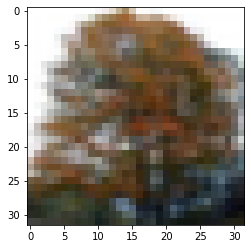

In [5]:
plt.imshow(x_train[56, :, :])

In [6]:
# Convertir a float32 para mejor manejo
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
# Normalizar los valores de las imágenes
x_train /= 255
x_test /= 255

In [7]:
print("Tamaño del conjunto de entrenamiento:", x_train.shape)
print(x_train.shape[0], "Muestras de entrenamiento")
print(x_test.shape[0], "Muestras de prueba")

Tamaño del conjunto de entrenamiento: (50000, 32, 32, 3)
50000 Muestras de entrenamiento
10000 Muestras de prueba


In [8]:
# Codificación One Hot para las etiquetas
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [10]:
arquitectura = [
    # Primera capa de características
    Conv2D(64, kernel_size=(3, 3), padding="same",
          input_shape=x_train.shape[1:],
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    Conv2D(64, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Segunda capa de características
    Conv2D(128, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    Conv2D(128, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Tercera capa de características
    Conv2D(256, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    Conv2D(256, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    Conv2D(256, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Cuarta capa de características
    Conv2D(512, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    Conv2D(512, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    Conv2D(512, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Quinta capa de características
    Conv2D(512, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    Conv2D(512, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    Conv2D(512, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regular_param_l2),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Primera capa totalmente conectada
    Flatten(),
    Dense(4096, activation="relu",
          kernel_regularizer=regular_param_l2),
    Dropout(0.5),
    Dense(4096, activation="relu",
          kernel_regularizer=regular_param_l2),
    Dropout(0.5),
    # Salida de la CNN
    Dense(num_classes, activation="softmax")
]

In [11]:
# Aplicar Early Stopping
es = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=15)
# Guardar siempre el mejor modelo encontrado en base a la precisión de validación
mc = ModelCheckpoint("mejor_modelo.h5", monitor="val_acc", mode="auto", verbose=1, save_best_only=True)
# Ajustar el ratio de aprendizaje
lr_ajuste = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)

In [13]:
vgg16 = Sequential(arquitectura)

In [15]:
vgg16.compile(loss="categorical_crossentropy",
             optimizer=SGD(1e-2, momentum=0.9),
             metrics=["accuracy"])

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=True,  # si es positivo, la media del conjunto de datos es 0
        samplewise_center=False,  # si es positivo, la medida de cada ejemplo es 0
        featurewise_std_normalization=False,  # divide el conjunto de datos por la desviación estándar
        samplewise_std_normalization=False,  # divide cada ejemplo por su propia desviación estándar
        zca_whitening=True,  # aplicar ruido tipo Zero-phase Component Analysis
        zca_epsilon=1e-06,  # valor del ruido tipo ZCA
        rotation_range=0,  # se rota aleatoriamente la imagen, el valor es entero de 0 a 180
        # traslación horizontal aleatoria, la fracción representa cuánto
        width_shift_range=0.1,
        # traslación vertical aleatoria, la fracción representa cuánto
        height_shift_range=0.1,
        shear_range=0.0,  # valor para distorsión
        zoom_range=0.2,  # valor para acercamiento
        channel_shift_range=0.,  # cambio de canales, de forma aleatoria
        # modo para rellenado de pixeles fuera de la imagen
        fill_mode="nearest",
        cval=0.0,  # en caso de que el rellenado sea "constant"
        horizontal_flip=True,  # reflexión horizontal aleatoria de las imágenes
        vertical_flip=True,  # reflexión vertical aleatoria de las imágenes
        # factor de reescalamiento (se aplica primero antes que cualquier transformación)
        rescale=None,
        # algún tipo de función definida por el usuario que haga transformaciones
        # i.e. filtro de Borel, transformada de Fourier, ruido rosa, etc.
        preprocessing_function=None,
        # especificar el tipo de datos que se están ingresando
        data_format=None,
        # fracción de imágenes para separar en entrenamieto y validación
        validation_split=0.2)

In [17]:
datagen.fit(x_train)

In [18]:
vgg16_model = load_model("mejor_modelo.h5")

W0821 14:43:01.178751 140300470384448 deprecation.py:323] From /home/edwinb/anaconda3/envs/deep_workshop/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [34]:
historia_vgg16 = vgg16_model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size,
                                    subset="training"),
                                    epochs=epocas,
                                    validation_data=datagen.flow(x_train, y_train,
                                                                batch_size=batch_size,
                                                                subset="validation"),
                                    steps_per_epoch=np.ceil(len(x_train) // batch_size),
                                    validation_steps=np.ceil(len(x_train) // batch_size),
                                    workers=2,
                                    callbacks=[es, mc, lr_ajuste],
                            verbose=1)

Epoch 1/50
781/781 [==============================] - 330s 423ms/step - loss: 2.7669 - acc: 0.4455 - val_loss: 2.9542 - val_acc: 0.4181

Epoch 00001: val_acc improved from -inf to 0.41810, saving model to /content/drive/My Drive/Colab Notebooks/mejor_modelo.h5
Epoch 2/50
781/781 [==============================] - 319s 408ms/step - loss: 2.7668 - acc: 0.4479 - val_loss: 2.8924 - val_acc: 0.4256

Epoch 00002: val_acc improved from 0.41810 to 0.42560, saving model to /content/drive/My Drive/Colab Notebooks/mejor_modelo.h5
Epoch 3/50
781/781 [==============================] - 320s 410ms/step - loss: 2.7444 - acc: 0.4554 - val_loss: 2.9289 - val_acc: 0.4213

Epoch 00003: val_acc did not improve from 0.42560
Epoch 4/50
781/781 [==============================] - 433s 554ms/step - loss: 2.7567 - acc: 0.4569 - val_loss: 2.9529 - val_acc: 0.4233

Epoch 00004: val_acc did not improve from 0.42560
Epoch 5/50
781/781 [==============================] - 464s 595ms/step - loss: 2.7258 - acc: 0.4626 - 

In [19]:
vgg16_model.evaluate(x_test, y_test)

10000/10000 [==============================] - 68s 7ms/step


[11.136509689331055, 0.009]